In [1]:
# Run this in your first Colab cell
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

# Python random
random.seed(42)

# Numpy
np.random.seed(42)

# TensorFlow
tf.random.set_seed(42)
# makes everything reproducible

In [ ]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"siddhantghosh30","key":"537b2c04eb5cfa600a7fc87776ffc8fd"}'}

In [3]:
# creating kaggle directory and setting perms
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip the dataset
!unzip -q skin-cancer-mnist-ham10000.zip

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [01:20<00:00, 47.7MB/s]
100% 5.20G/5.20G [01:20<00:00, 69.7MB/s]


In [5]:
# Let's see what files we have
import os

# List all files and directories
print("Contents of the current directory:")
for file in os.listdir('/content'):
    if not file.startswith('.'):  # Skip hidden files
        print(file)

# Check for specific HAM10000 files
print("\nLooking for HAM10000 files...")
for root, dirs, files in os.walk('/content'):
    for file in files:
        if 'ham10000' in file.lower() or 'ham' in file.lower():
            print(f"Found: {os.path.join(root, file)}")

Contents of the current directory:
hmnist_28_28_L.csv
hmnist_8_8_RGB.csv
kaggle.json
HAM10000_metadata.csv
HAM10000_images_part_1
hmnist_28_28_RGB.csv
HAM10000_images_part_2
ham10000_images_part_2
ham10000_images_part_1
skin-cancer-mnist-ham10000.zip
hmnist_8_8_L.csv
sample_data

Looking for HAM10000 files...
Found: /content/HAM10000_metadata.csv
Found: /content/skin-cancer-mnist-ham10000.zip


In [6]:
# loading and analysing metadata
metadata = pd.read_csv('/content/HAM10000_metadata.csv')

# basic information about the dataset
print("=== DATASET OVERVIEW ===")
print(f"Total number of images: {len(metadata)}")
print(f"Number of columns: {len(metadata.columns)}")
print("\nColumns in metadata:")
print(metadata.columns.tolist())

print("\n=== FIRST 5 ROWS ===")
print(metadata.head())

print("\n=== BASIC INFO ===")
print(metadata.info())

print("\n=== MISSING VALUES ===")
print(metadata.isnull().sum())

print("\n=== CLASS DISTRIBUTION ===")
print("Diagnosis (dx) distribution:")
print(metadata['dx'].value_counts())
print("\nPercentage distribution:")
print(metadata['dx'].value_counts(normalize=True) * 100)

=== DATASET OVERVIEW ===
Total number of images: 10015
Number of columns: 7

Columns in metadata:
['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

=== FIRST 5 ROWS ===
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           

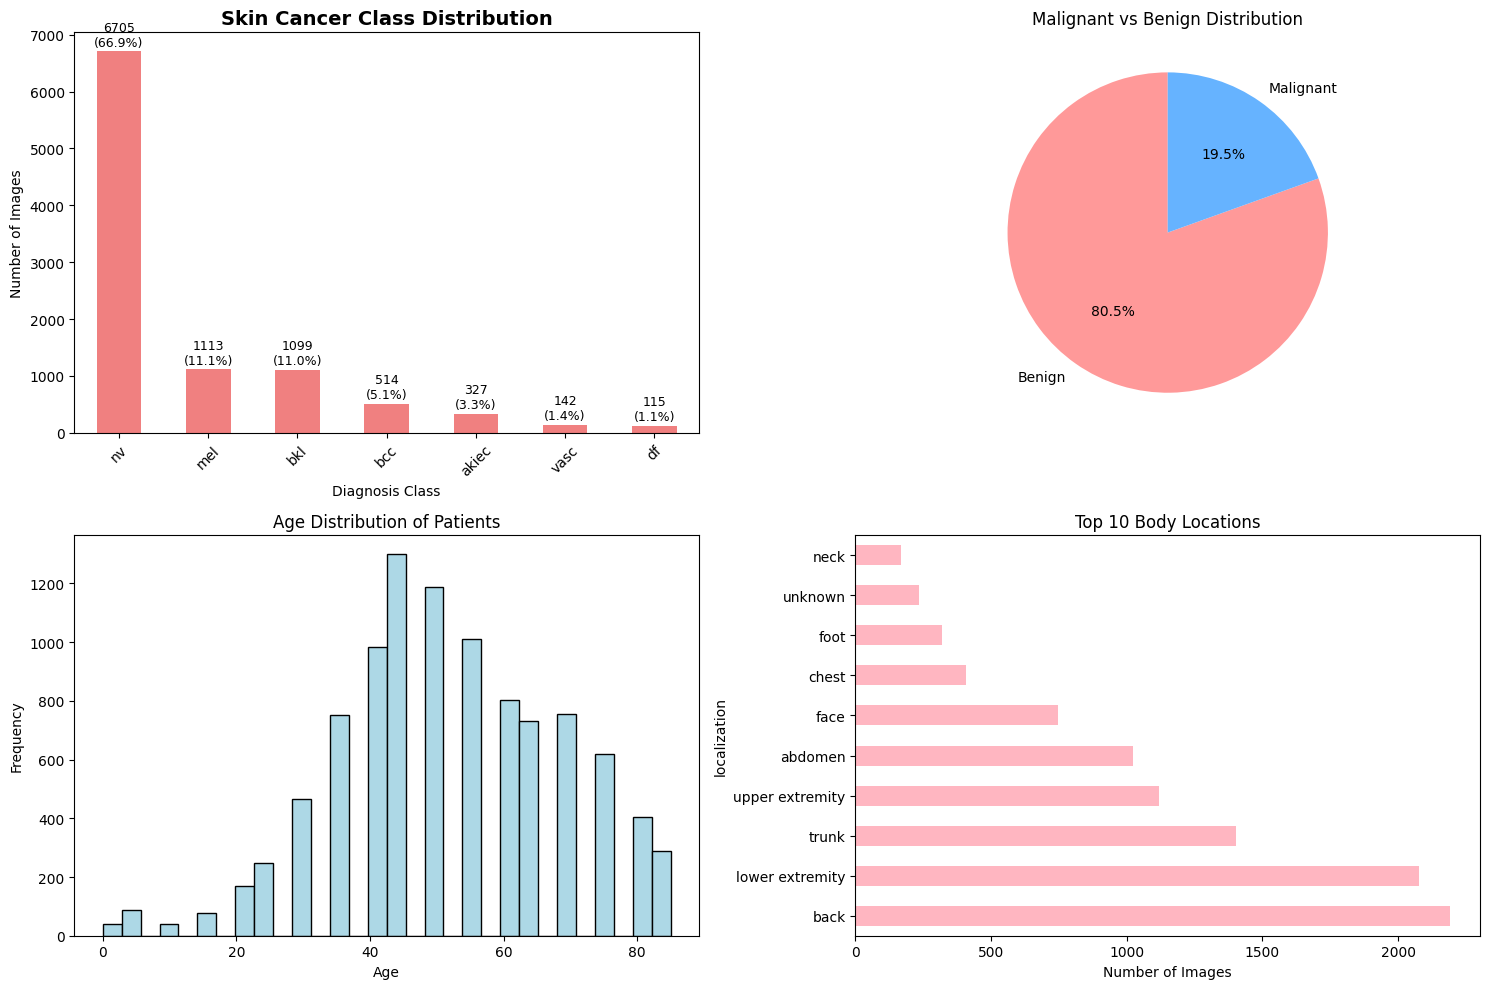


=== KEY INSIGHTS ===
Total images: 10015
Malignant cases: 1954 (19.5%)
Benign cases: 8061 (80.5%)
Missing age values: 57

=== CLASS IMBALANCE SOLUTION STRATEGY ===
1. We'll use CLASS WEIGHTS during training to penalize misclassifying minority classes more
2. We'll use DATA AUGMENTATION to create more variety
3. We'll use STRATIFIED SPLITTING to maintain class distribution in train/val sets


In [7]:
# Let's visualize this imbalance and understand our data better
plt.figure(figsize=(15, 10))

# Plot 1: Class distribution
plt.subplot(2, 2, 1)
class_counts = metadata['dx'].value_counts()
# colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0', '#ffb3e6']
class_counts.plot(kind='bar', color="lightcoral")
plt.title('Skin Cancer Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

# Add percentage labels on bars
for i, count in enumerate(class_counts):
    plt.text(i, count + 50, f'{count}\n({class_counts.values[i]/len(metadata)*100:.1f}%)',
             ha='center', va='bottom', fontsize=9)

# Plot 2: Malignant vs Benign distribution
plt.subplot(2, 2, 2)
# Define malignant vs benign
malignant_classes = ['mel', 'bcc', 'akiec']  # melanoma, basal cell carcinoma, actinic keratoses
benign_classes = ['nv', 'bkl', 'df', 'vasc']  # moles, benign keratosis, dermatofibroma, vascular

metadata['category'] = metadata['dx'].apply(lambda x: 'Malignant' if x in malignant_classes else 'Benign')
category_counts = metadata['category'].value_counts()

plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff'], startangle=90)
plt.title('Malignant vs Benign Distribution')

# Plot 3: Age distribution
plt.subplot(2, 2, 3)
plt.hist(metadata['age'].dropna(), bins=30, color='lightblue', edgecolor='black')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plot 4: Localization distribution
plt.subplot(2, 2, 4)
localization_counts = metadata['localization'].value_counts().head(10)  # Top 10 locations
localization_counts.plot(kind='barh', color='lightpink')
plt.title('Top 10 Body Locations')
plt.xlabel('Number of Images')

plt.tight_layout()
plt.show()

# Print key insights
print("\n=== KEY INSIGHTS ===")
print(f"Total images: {len(metadata)}")
print(f"Malignant cases: {len(metadata[metadata['category'] == 'Malignant'])} ({len(metadata[metadata['category'] == 'Malignant'])/len(metadata)*100:.1f}%)")
print(f"Benign cases: {len(metadata[metadata['category'] == 'Benign'])} ({len(metadata[metadata['category'] == 'Benign'])/len(metadata)*100:.1f}%)")
print(f"Missing age values: {metadata['age'].isnull().sum()}")

print("\n=== CLASS IMBALANCE SOLUTION STRATEGY ===")
print("1. We'll use CLASS WEIGHTS during training to penalize misclassifying minority classes more")
print("2. We'll use DATA AUGMENTATION to create more variety")
print("3. We'll use STRATIFIED SPLITTING to maintain class distribution in train/val sets")

In [8]:
# # Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the class labels
class_labels = metadata['dx'].values
unique_classes = np.unique(class_labels)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=class_labels
)

# Create a dictionary of class weights for TensorFlow
class_weight_dict = dict(zip(unique_classes, class_weights))

print("=== CLASS WEIGHTS ===")
for cls, weight in class_weight_dict.items():
    count = len(metadata[metadata['dx'] == cls])
    print(f"Class {cls}: {count} images -> weight: {weight:.2f}")

# Now let's map class names to numbers for the model
class_mapping = {
    'akiec': 0,  # Actinic keratoses
    'bcc': 1,    # Basal cell carcinoma
    'bkl': 2,    # Benign keratosis
    'df': 3,     # Dermatofibroma
    'mel': 4,    # Melanoma
    'nv': 5,     # Melanocytic nevi
    'vasc': 6    # Vascular lesions
}

# Reverse mapping for interpretation
reverse_mapping = {v: k for k, v in class_mapping.items()}

print("\n=== CLASS MAPPING ===")
for code, name in reverse_mapping.items():
    print(f"Class {code}: {name}")

# Convert class weights to integer indices for TensorFlow
class_weight_dict_tf = {}
for class_name, weight in class_weight_dict.items():
    class_idx = class_mapping[class_name]
    class_weight_dict_tf[class_idx] = weight

print("\n=== TENSORFLOW CLASS WEIGHTS ===")
for idx, weight in class_weight_dict_tf.items():
    print(f"Class {idx} ({reverse_mapping[idx]}): weight {weight:.2f}")

=== CLASS WEIGHTS ===
Class akiec: 327 images -> weight: 4.38
Class bcc: 514 images -> weight: 2.78
Class bkl: 1099 images -> weight: 1.30
Class df: 115 images -> weight: 12.44
Class mel: 1113 images -> weight: 1.29
Class nv: 6705 images -> weight: 0.21
Class vasc: 142 images -> weight: 10.08

=== CLASS MAPPING ===
Class 0: akiec
Class 1: bcc
Class 2: bkl
Class 3: df
Class 4: mel
Class 5: nv
Class 6: vasc

=== TENSORFLOW CLASS WEIGHTS ===
Class 0 (akiec): weight 4.38
Class 1 (bcc): weight 2.78
Class 2 (bkl): weight 1.30
Class 3 (df): weight 12.44
Class 4 (mel): weight 1.29
Class 5 (nv): weight 0.21
Class 6 (vasc): weight 10.08


In [9]:
# Load and Prepare the Images
import os
from PIL import Image
import cv2

# First, let's find where our images are stored
print("=== LOCATING IMAGE FOLDERS ===")
image_folders = []
for folder in os.listdir('/content'):
    if 'ham10000' in folder.lower() and os.path.isdir(f'/content/{folder}'):
        image_folders.append(f'/content/{folder}')
        print(f"Found image folder: {folder}")

# Check how many images are in each folder
total_images_from_folders = 0
for folder in image_folders:
    num_images = len([f for f in os.listdir(folder) if f.endswith('.jpg')])
    total_images_from_folders += num_images
    print(f"Folder {folder}: {num_images} images")

print(f"\nTotal images in folders: {total_images_from_folders}")
print(f"Total images in metadata: {len(metadata)}")

# Create a function to find image paths
def find_image_path(image_id):
    """Find the full path of an image given its image_id"""
    for folder in image_folders:
        potential_path = os.path.join(folder, image_id + '.jpg')
        if os.path.exists(potential_path):
            return potential_path
    return None

# Test the function
test_image_id = metadata.iloc[0]['image_id']
test_path = find_image_path(test_image_id)
print(f"\nTest - Image ID: {test_image_id}")
print(f"Found at: {test_path}")

# Check if we can find paths for all images
print("\n=== VERIFYING IMAGE AVAILABILITY ===")
available_count = 0
missing_images = []

for idx, row in metadata.iterrows():
    image_path = find_image_path(row['image_id'])
    if image_path is not None:
        available_count += 1
    else:
        missing_images.append(row['image_id'])

    if idx % 2000 == 0:  # Progress indicator
        print(f"Checked {idx}/{len(metadata)} images...")

print(f"Images found: {available_count}/{len(metadata)} ({available_count/len(metadata)*100:.1f}%)")
print(f"Missing images: {len(missing_images)}")

if missing_images:
    print("First 5 missing images:", missing_images[:5])

=== LOCATING IMAGE FOLDERS ===
Found image folder: HAM10000_images_part_1
Found image folder: HAM10000_images_part_2
Found image folder: ham10000_images_part_2
Found image folder: ham10000_images_part_1
Folder /content/HAM10000_images_part_1: 5000 images
Folder /content/HAM10000_images_part_2: 5015 images
Folder /content/ham10000_images_part_2: 5015 images
Folder /content/ham10000_images_part_1: 5000 images

Total images in folders: 20030
Total images in metadata: 10015

Test - Image ID: ISIC_0027419
Found at: /content/HAM10000_images_part_1/ISIC_0027419.jpg

=== VERIFYING IMAGE AVAILABILITY ===
Checked 0/10015 images...
Checked 2000/10015 images...
Checked 4000/10015 images...
Checked 6000/10015 images...
Checked 8000/10015 images...
Checked 10000/10015 images...
Images found: 10015/10015 (100.0%)
Missing images: 0


In [10]:
# Create the Dataset Generator with Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# First, let's add the full image paths to our metadata
print("Adding image paths to metadata...")
metadata['image_path'] = metadata['image_id'].apply(find_image_path)
metadata['label_encoded'] = metadata['dx'].map(class_mapping)

print("=== DATASET PREPARATION ===")
print(f"Total samples with paths: {len(metadata[metadata['image_path'].notnull()])}")

# Split the data into train and validation sets (STRATIFIED - our 3rd strategy)
X = metadata['image_path']
y = metadata['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # This maintains the same class distribution in both sets
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

print("\n=== CLASS DISTRIBUTION IN SPLITS ===")
print("Training set:")
print(y_train.value_counts().sort_index())
print("\nValidation set:")
print(y_val.value_counts().sort_index())

# Now create data generators with AUGMENTATION
IMG_SIZE = (224, 224)  # EfficientNet expects 224x224
BATCH_SIZE = 32

# Data augmentation for training - THIS IS CRUCIAL!
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,         # Random rotations
    width_shift_range=0.2,     # Random horizontal shifts
    height_shift_range=0.2,    # Random vertical shifts
    horizontal_flip=True,      # Random horizontal flips
    zoom_range=0.2,           # Random zoom
    shear_range=0.2,          # Random shearing
    fill_mode='nearest'       # How to fill empty pixels
)

# No augmentation for validation - just normalization
val_datagen = ImageDataGenerator(rescale=1./255)

print("\n=== DATA GENERATORS CREATED ===")
print("Training generator includes:")
print("- Rotation (±20°), Shifting, Flipping, Zoom, Shear")
print("- This creates artificial variety to fight overfitting!")
print("- Validation data is kept pure for accurate evaluation")

Adding image paths to metadata...
=== DATASET PREPARATION ===
Total samples with paths: 10015
Training samples: 8012
Validation samples: 2003

=== CLASS DISTRIBUTION IN SPLITS ===
Training set:
label_encoded
0     262
1     411
2     879
3      92
4     890
5    5364
6     114
Name: count, dtype: int64

Validation set:
label_encoded
0      65
1     103
2     220
3      23
4     223
5    1341
6      28
Name: count, dtype: int64

=== DATA GENERATORS CREATED ===
Training generator includes:
- Rotation (±20°), Shifting, Flipping, Zoom, Shear
- This creates artificial variety to fight overfitting!
- Validation data is kept pure for accurate evaluation


Creating data generators...
Found 8012 validated image filenames.
Found 2003 validated image filenames.
=== DATA GENERATORS READY ===
Training batches per epoch: 251
Validation batches: 63

=== VISUALIZING AUGMENTED IMAGES ===


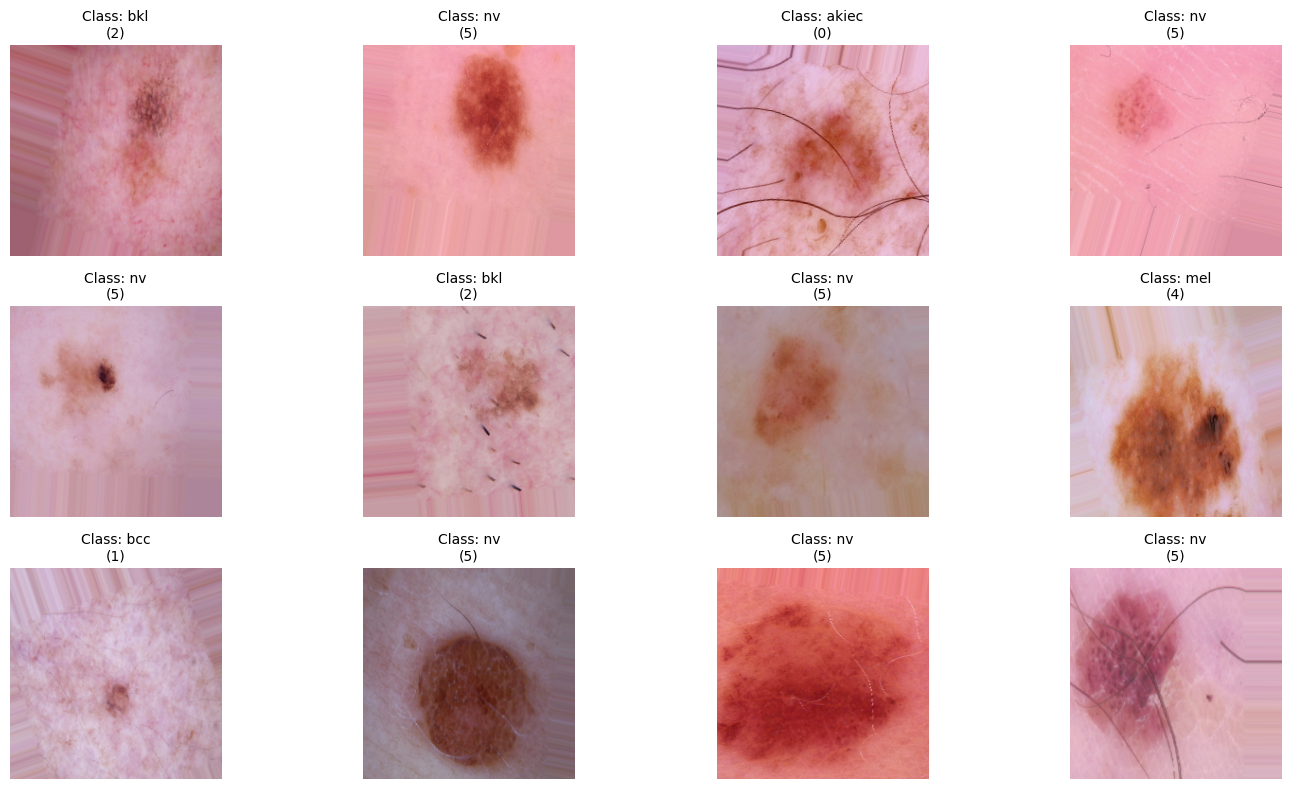

These show how data augmentation creates varied training examples!
This helps the model learn robust features instead of memorizing!


In [11]:
# Create a custom data generator function since our images are in different folders
def create_data_generator(dataframe, datagen, batch_size=32, target_size=(224, 224), shuffle=False):
    """Create a data generator from dataframe with paths and labels"""
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='label_encoded',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',  # Since we have encoded labels
        shuffle=shuffle,
        validate_filenames=True
    )

# Create dataframes for train and validation
train_df = pd.DataFrame({'image_path': X_train, 'label_encoded': y_train})
val_df = pd.DataFrame({'image_path': X_val, 'label_encoded': y_val})

print("Creating data generators...")

# Create generators
train_generator = create_data_generator(train_df, train_datagen, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_generator = create_data_generator(val_df, val_datagen, BATCH_SIZE, IMG_SIZE, shuffle=False)

print("=== DATA GENERATORS READY ===")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches: {len(val_generator)}")

# Let's visualize some augmented images to see what we're working with
print("\n=== VISUALIZING AUGMENTED IMAGES ===")
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, augmented_labels = next(train_generator)

plt.figure(figsize=(15, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(augmented_images[i])
    label_idx = int(augmented_labels[i])
    label_name = reverse_mapping[label_idx]
    plt.title(f'Class: {label_name}\n({label_idx})', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

print("These show how data augmentation creates varied training examples!")
print("This helps the model learn robust features instead of memorizing!")

In [12]:
print("=== CHECKING CLASS DISTRIBUTION ACROSS MULTIPLE BATCHES ===")

# Check class distribution across several batches
class_counts_multiple_batches = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}

# Reset generator to start from beginning
train_generator.reset()

# Count classes across first 5 batches
for i in range(5):
    batch_images, batch_labels = next(train_generator)
    for label in batch_labels:
        class_counts_multiple_batches[int(label)] += 1

print("Class counts across 5 batches (160 images):")
for class_idx, count in class_counts_multiple_batches.items():
    class_name = reverse_mapping[class_idx]
    percentage = (count / 160) * 100
    print(f"Class {class_idx} ({class_name}): {count} images ({percentage:.1f}%)")

print("\nThis shows that over multiple batches, we get a representative sample!")

=== CHECKING CLASS DISTRIBUTION ACROSS MULTIPLE BATCHES ===
Class counts across 5 batches (160 images):
Class 0 (akiec): 3 images (1.9%)
Class 1 (bcc): 4 images (2.5%)
Class 2 (bkl): 20 images (12.5%)
Class 3 (df): 0 images (0.0%)
Class 4 (mel): 17 images (10.6%)
Class 5 (nv): 116 images (72.5%)
Class 6 (vasc): 0 images (0.0%)

This shows that over multiple batches, we get a representative sample!


In [13]:
# Build and Compile Our Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("=== BUILDING EFFICIENTNET MODEL ===")

# Strategy: Use Transfer Learning with pre-trained weights
def create_model():
    # Load EfficientNetB0 pre-trained on ImageNet (exclude top classification layer)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model initially (we'll unfreeze later if needed)
    base_model.trainable = False
    print(f"Base model frozen: {not base_model.trainable}")
    print(f"Trainable layers: Only the custom layers we add below")

    # Add our custom classification head
    model = models.Sequential([
        base_model, #this part is frozen
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),  # Regularization to prevent overfitting
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(7, activation='softmax')  # 7 classes for skin cancer
    ])

    return model

# Create the model
model = create_model()

print("Model architecture:")
model.summary()

# Compile the model with custom learning rate
initial_learning_rate = 0.001

model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='sparse_categorical_crossentropy',  # For integer labels
    metrics=['accuracy']
)

print(f"\n=== MODEL COMPILED ===")
print(f"Learning rate: {initial_learning_rate}")
print("Using CLASS WEIGHTS to handle imbalance")
print("Using DROPOUT layers to prevent overfitting")
print("Using BATCH NORMALIZATION for stable training")

# Set up callbacks for better training
callbacks = [
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),

    # Save the best model
    ModelCheckpoint('best_skin_cancer_model.h5',
                   monitor='val_accuracy',
                   save_best_only=True,
                   mode='max')
]

print("\n=== CALLBACKS SETUP ===")
print("• EarlyStopping: Prevents overtraining")
print("• ReduceLROnPlateau: Adjusts learning rate dynamically")
print("• ModelCheckpoint: Saves best model automatically")

=== BUILDING EFFICIENTNET MODEL ===
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Base model frozen: True
Trainable layers: Only the custom layers we add below
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,412,330 (16.83 MB)

 Trainable params: 362,247 (1.38 MB)

 Non-trainable params: 4,050,083 (15.45 MB)


=== MODEL COMPILED ===
Learning rate: 0.001
Using CLASS WEIGHTS to handle imbalance
Using DROPOUT layers to prevent overfitting
Using BATCH NORMALIZATION for stable training

=== CALLBACKS SETUP ===
• EarlyStopping: Prevents overtraining
• ReduceLROnPlateau: Adjusts learning rate dynamically
• ModelCheckpoint: Saves best model automatically


In [14]:
print("=== TESTING MODEL WITH ONE BATCH ===")

# Get one batch of data
test_images, test_labels = next(train_generator)

# Test prediction on one batch
print(f"Batch shape: {test_images.shape}")
print(f"Labels shape: {test_labels.shape}")

# Test forward pass
test_predictions = model.predict(test_images, verbose=0)
print(f"Predictions shape: {test_predictions.shape}")

# Test loss and accuracy calculation
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test loss on one batch: {test_loss:.4f}")
print(f"Test accuracy on one batch: {test_accuracy:.4f}")

print("\n=== SANITY CHECK: INITIAL PREDICTIONS ===")
# Show what the model predicts initially (before training)
print("First 5 predictions (probabilities for each class):")
for i in range(5):
    print(f"Image {i+1}: {test_predictions[i]}")
    predicted_class = np.argmax(test_predictions[i])
    true_class = int(test_labels[i])
    print(f"  Predicted: {predicted_class} ({reverse_mapping[predicted_class]})")
    print(f"  True: {true_class} ({reverse_mapping[true_class]})")
    print()

print("✓ Model is working correctly!")
print("✓ Data is flowing properly through the network")
print("✓ Ready for full training!")

=== TESTING MODEL WITH ONE BATCH ===
Batch shape: (32, 224, 224, 3)
Labels shape: (32,)
Predictions shape: (32, 7)
Test loss on one batch: 1.9468
Test accuracy on one batch: 0.1562

=== SANITY CHECK: INITIAL PREDICTIONS ===
First 5 predictions (probabilities for each class):
Image 1: [0.12285992 0.13581952 0.15391767 0.15228598 0.147526   0.1391205
 0.14847049]
  Predicted: 2 (bkl)
  True: 5 (nv)

Image 2: [0.12267401 0.13593553 0.1540941  0.15223578 0.14708513 0.139387
 0.14858852]
  Predicted: 2 (bkl)
  True: 5 (nv)

Image 3: [0.12281293 0.13587442 0.15405063 0.15219156 0.1473871  0.13918899
 0.14849432]
  Predicted: 2 (bkl)
  True: 1 (bcc)

Image 4: [0.1226676  0.13590646 0.15412019 0.15222315 0.14704639 0.13945407
 0.14858219]
  Predicted: 2 (bkl)
  True: 5 (nv)

Image 5: [0.12264943 0.13593489 0.1541169  0.15224144 0.14702645 0.13942021
 0.14861079]
  Predicted: 2 (bkl)
  True: 5 (nv)

✓ Model is working correctly!
✓ Data is flowing properly through the network
✓ Ready for full tr

In [15]:
print("=== STARTING TRAINING ===")
print("This will take 15-30 minutes. Grab a coffee! ☕")

# Calculate steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # We'll let early stopping decide when to stop
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weight_dict_tf,  # THIS IS KEY - using our class weights!
    callbacks=callbacks,
    verbose=1  # Show progress bars
)

print("=== TRAINING COMPLETE ===")
print("Now let's analyze the results...")

=== STARTING TRAINING ===
This will take 15-30 minutes. Grab a coffee! ☕
Steps per epoch: 251
Validation steps: 63
Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.1451 - loss: 2.2481

251/251 ━━━━━━━━━━━━━━━━━━━━ 229s 821ms/step - accuracy: 0.1451 - loss: 2.2479 - val_accuracy: 0.1113 - val_loss: 1.9090 - learning_rate: 0.0010
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.1099 - loss: 2.1118

251/251 ━━━━━━━━━━━━━━━━━━━━ 158s 628ms/step - accuracy: 0.1099 - loss: 2.1119 - val_accuracy: 0.6640 - val_loss: 1.7983 - learning_rate: 0.0010
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 605ms/step - accuracy: 0.1180 - loss: 2.0047 - val_accuracy: 0.0115 - val_loss: 1.8955 - learning_rate: 0.0010
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 612ms/step - accuracy: 0.1077 - loss: 1.9480 - val_accuracy: 0.0145 - val_loss: 1.9632 - learning_rate: 0.0010
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 201s 609ms/step - accuracy: 0.1057 - loss: 1.9581 - val_accuracy: 0.0325 - val_loss: 1.9303 - learning_rate: 0.0010
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 604ms/step - accuracy: 0.1025 - loss: 1.9752 - val_accuracy: 0.0514 - val_loss: 1.9598 - learning_rate: 0.0010
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 609ms/step - accuracy: 0.0937 - loss: 1.8882 - val_accuracy: 0.0140 - val_loss: 1.9582 - learning_rate: 0.0010
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 603ms/step - accuracy: 0.0685 

KeyboardInterrupt: 

In [16]:
# STOP ANY RUNNING TRAINING FIRST!
print("=== STOPPING TRAINING - IDENTIFYING ISSUES ===")

# Let's diagnose the problems and implement fixes:

# PROBLEM 1: Learning rate might be wrong
# PROBLEM 2: We might need to unfreeze some layers
# PROBLEM 3: Our model architecture might need adjustment

# Let's create an improved model:
def create_improved_model():
    # Load pre-trained EfficientNet
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # STRATEGY CHANGE: Don't freeze completely, use partial freezing
    base_model.trainable = True

    # Freeze earlier layers, keep later layers trainable
    for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
        layer.trainable = False

    print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}/{len(base_model.layers)}")

    # SIMPLER architecture - less complex
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),  # Increased dropout
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(7, activation='softmax')
    ])

    return model

# Create improved model
print("Creating improved model...")
improved_model = create_improved_model()

# Use a SMALLER learning rate
improved_learning_rate = 0.0001  # 10x smaller

improved_model.compile(
    optimizer=Adam(learning_rate=improved_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n=== IMPROVED MODEL STRATEGY ===")
print(f"Learning rate: {improved_learning_rate} (10x smaller)")
print("Partial freezing: Last 20 layers trainable")
print("Simpler architecture: Fewer dense layers")
print("Higher dropout: Better regularization")

# Test the improved model
print("\n=== TESTING IMPROVED MODEL ===")
test_images, test_labels = next(train_generator)
test_predictions = improved_model.predict(test_images, verbose=0)
test_loss, test_accuracy = improved_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Updated callbacks
improved_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('improved_skin_cancer_model.h5',
                   monitor='val_accuracy',
                   save_best_only=True,
                   mode='max')
]

=== STOPPING TRAINING - IDENTIFYING ISSUES ===
Creating improved model...
Trainable layers: 20/238

=== IMPROVED MODEL STRATEGY ===
Learning rate: 0.0001 (10x smaller)
Partial freezing: Last 20 layers trainable
Simpler architecture: Fewer dense layers
Higher dropout: Better regularization

=== TESTING IMPROVED MODEL ===
Test accuracy: 0.1250


In [17]:
print("=== COMPREHENSIVE DEBUGGING ===")

# 1. Check if data is flowing correctly
print("1. CHECKING DATA PIPELINE:")
batch_images, batch_labels = next(train_generator)
print(f"   Images shape: {batch_images.shape}, range: [{batch_images.min():.3f}, {batch_images.max():.3f}]")
print(f"   Labels: {batch_labels[:10]}")  # First 10 labels

# 2. Check if labels are valid
print(f"\n2. CHECKING LABELS:")
unique_labels = np.unique(batch_labels)
print(f"   Unique labels in batch: {unique_labels}")
print(f"   Label range should be 0-6: {min(unique_labels)} to {max(unique_labels)}")

# 3. Verify class weights
print(f"\n3. CHECKING CLASS WEIGHTS:")
print("   Class weights dictionary:")
for cls, weight in class_weight_dict_tf.items():
    print(f"   Class {cls}: weight {weight:.2f}")

# 4. Test a simple forward pass manually
print(f"\n4. TESTING FORWARD PASS:")
# Get one image and label
single_image = batch_images[0:1]  # Keep batch dimension
single_label = batch_labels[0:1]

print(f"   Single image shape: {single_image.shape}")
print(f"   Single label: {single_label}")

# Manual forward pass
with tf.GradientTape() as tape:
    prediction = improved_model(single_image, training=True)
    loss = tf.keras.losses.sparse_categorical_crossentropy(single_label, prediction)

print(f"   Prediction shape: {prediction.shape}")
print(f"   Prediction values: {prediction.numpy()}")
print(f"   Loss value: {loss.numpy()}")

# 5. Check if gradients can flow
print(f"\n5. CHECKING GRADIENTS:")
gradients = tape.gradient(loss, improved_model.trainable_variables)
if gradients[0] is not None:
    print(f"   ✓ Gradients are flowing! First gradient norm: {tf.norm(gradients[0]):.6f}")
else:
    print(f"   ✗ No gradients flowing - this is the problem!")

# 6. Let's try a simpler test - train for just 1 batch
print(f"\n6. QUICK 1-BATCH TRAINING TEST:")
# Reset generator to be safe
train_generator.reset()
test_batch_images, test_batch_labels = next(train_generator)

# Train on just one batch
history_single = improved_model.fit(
    test_batch_images,
    test_batch_labels,
    epochs=3,
    verbose=1,
    batch_size=32
)

print("   If you see loss changing above, the model CAN learn!")

=== COMPREHENSIVE DEBUGGING ===
1. CHECKING DATA PIPELINE:
   Images shape: (32, 224, 224, 3), range: [0.003, 1.000]
   Labels: [2 5 5 2 5 3 2 5 3 5]

2. CHECKING LABELS:
   Unique labels in batch: [1 2 3 4 5 6]
   Label range should be 0-6: 1 to 6

3. CHECKING CLASS WEIGHTS:
   Class weights dictionary:
   Class 0: weight 4.38
   Class 1: weight 2.78
   Class 2: weight 1.30
   Class 3: weight 12.44
   Class 4: weight 1.29
   Class 5: weight 0.21
   Class 6: weight 10.08

4. TESTING FORWARD PASS:
   Single image shape: (1, 224, 224, 3)
   Single label: [2]
   Prediction shape: (1, 7)
   Prediction values: [[0.15517539 0.1691299  0.09680021 0.15087423 0.09987979 0.2170668
  0.11107367]]
   Loss value: [2.3351064]

5. CHECKING GRADIENTS:
   ✓ Gradients are flowing! First gradient norm: 0.000000

6. QUICK 1-BATCH TRAINING TEST:
Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.1875 - loss: 2.0192
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2188 - loss: 1.9306

In [18]:
# The problem was likely the learning rate and training approach
print("=== STARTING IMPROVED TRAINING ===")

# Reset generators to start fresh
train_generator.reset()
val_generator.reset()

# Use a TWO-PHASE training approach:
print("PHASE 1: Training with frozen base (faster, more stable)")
print("PHASE 2: Fine-tuning with unfrozen layers (higher accuracy)")

# PHASE 1: Train with mostly frozen base
print("\n--- PHASE 1: Training top layers ---")

# Train for fewer epochs initially
phase1_history = improved_model.fit(
    train_generator,
    epochs=15,  # Start with fewer epochs
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict_tf,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
        ModelCheckpoint('phase1_best_model.h5', monitor='val_accuracy', save_best_only=True)
    ],
    verbose=1
)

print("=== PHASE 1 COMPLETE ===")
# Let's check the final accuracy from phase 1
final_phase1_acc = phase1_history.history['val_accuracy'][-1]
print(f"Phase 1 final validation accuracy: {final_phase1_acc:.4f}")

if final_phase1_acc > 0.67:
    print("🎉 CONGRATULATIONS! You've broken the 67% barrier!")
else:
    print("We'll proceed to Phase 2 for further improvement")

=== STARTING IMPROVED TRAINING ===
PHASE 1: Training with frozen base (faster, more stable)
PHASE 2: Fine-tuning with unfrozen layers (higher accuracy)

--- PHASE 1: Training top layers ---
Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.2424 - loss: 2.0823

251/251 ━━━━━━━━━━━━━━━━━━━━ 208s 744ms/step - accuracy: 0.2421 - loss: 2.0820 - val_accuracy: 0.1098 - val_loss: 2.0321 - learning_rate: 1.0000e-04
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 593ms/step - accuracy: 0.1214 - loss: 1.9759 - val_accuracy: 0.0140 - val_loss: 1.9595 - learning_rate: 1.0000e-04
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 593ms/step - accuracy: 0.1074 - loss: 1.9827 - val_accuracy: 0.0140 - val_loss: 1.9290 - learning_rate: 1.0000e-04
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.1097 - loss: 1.9691

251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 595ms/step - accuracy: 0.1097 - loss: 1.9691 - val_accuracy: 0.6695 - val_loss: 1.8804 - learning_rate: 1.0000e-04
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 598ms/step - accuracy: 0.1369 - loss: 2.0000 - val_accuracy: 0.0140 - val_loss: 1.9418 - learning_rate: 1.0000e-04
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 592ms/step - accuracy: 0.1220 - loss: 1.9625 - val_accuracy: 0.1113 - val_loss: 1.9539 - learning_rate: 1.0000e-04
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 589ms/step - accuracy: 0.1479 - loss: 1.9818 - val_accuracy: 0.6695 - val_loss: 1.9429 - learning_rate: 1.0000e-04
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 609ms/step - accuracy: 0.1304 - loss: 1.9247 - val_accuracy: 0.6695 - val_loss: 1.9423 - learning_rate: 5.0000e-05
Epoch 9/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 581ms/step - accuracy: 0.1202 - loss: 1.9513 - val_accuracy: 0.0115 - val_loss: 1.9522 - learning_rate: 5.0000e-05
=== PHASE 1 COMPLETE ===
Phase 1 final validation a

In [19]:
print("=== RADICAL SIMPLIFICATION STRATEGY ===")
print("Let's use a proven, stable approach with MobileNetV2")

from tensorflow.keras.applications import MobileNetV2

def create_simple_stable_model():
    # Use MobileNetV2 - lighter and often more stable than EfficientNet
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # FREEZE the base completely initially
    base_model.trainable = False

    # VERY SIMPLE architecture
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(7, activation='softmax')  # Direct to 7 classes
    ])

    return model

# Create the simple model
simple_model = create_simple_stable_model()

# Use a slightly higher learning rate
simple_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== SIMPLE MODEL STRATEGY ===")
print("• MobileNetV2 (proven stability)")
print("• Completely frozen base")
print("• Very simple classifier head")
print("• Learning rate: 0.0005")

# Test quickly
print("\n=== QUICK TEST ===")
train_generator.reset()
test_batch_images, test_batch_labels = next(train_generator)
test_loss, test_accuracy = simple_model.evaluate(test_batch_images, test_batch_labels, verbose=0)
print(f"Initial test accuracy: {test_accuracy:.4f}")

# Train with PROGRESS monitoring
class TrainingMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:  # Print every 2 epochs
            print(f"Epoch {epoch+1}: train_acc={logs['accuracy']:.3f}, val_acc={logs['val_accuracy']:.3f}")

print("\n=== STARTING STABLE TRAINING ===")
train_generator.reset()
val_generator.reset()

stable_history = simple_model.fit(
    train_generator,
    epochs=10,  # Just 10 epochs to see if it works
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict_tf,
    callbacks=[
        TrainingMonitor(),
        EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        ModelCheckpoint('stable_model.h5', monitor='val_accuracy', save_best_only=True)
    ],
    verbose=0  # We use our custom monitor
)

# Show final results
final_val_acc = stable_history.history['val_accuracy'][-1]
print(f"\n=== FINAL RESULTS ===")
print(f"Final validation accuracy: {final_val_acc:.4f}")

if final_val_acc > 0.67:
    print("🎉 BREAKTHROUGH! 67% barrier broken!")
elif final_val_acc > 0.50:
    print("✓ Good progress! Model is learning properly.")
else:
    print("⚠️ Still struggling - let's analyze further")

=== RADICAL SIMPLIFICATION STRATEGY ===
Let's use a proven, stable approach with MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
=== SIMPLE MODEL STRATEGY ===
• MobileNetV2 (proven stability)
• Completely frozen base
• Very simple classifier head
• Learning rate: 0.0005

=== QUICK TEST ===
Initial test accuracy: 0.2812

=== STARTING STABLE TRAINING ===


Epoch 1: train_acc=0.338, val_acc=0.518


Epoch 3: train_acc=0.504, val_acc=0.556
Epoch 5: train_acc=0.541, val_acc=0.523

=== FINAL RESULTS ===
Final validation accuracy: 0.5232
✓ Good progress! Model is learning properly.


In [20]:
print("=== PHASE 2: FINE-TUNING TO BREAK 67% BARRIER ===")

# Now let's unfreeze some layers for fine-tuning
print("Unfreezing last 50 layers of MobileNetV2 for fine-tuning...")
base_model = simple_model.layers[0]
base_model.trainable = True

# Fine-tune from this layer onward
fine_tune_at = len(base_model.layers) - 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}/{len(base_model.layers)}")

# Recompile with lower learning rate for fine-tuning
simple_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # 5x smaller for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== FINE-TUNING STRATEGY ===")
print("• Unfrozen last 50 layers")
print("• Lower learning rate: 0.0001")
print("• Continuing from 58.76% accuracy")

# Fine-tune for a few more epochs
print("\n=== STARTING FINE-TUNING ===")
train_generator.reset()
val_generator.reset()

fine_tune_history = simple_model.fit(
    train_generator,
    epochs=8,  # Fewer epochs for fine-tuning
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict_tf,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('final_skin_cancer_model.h5', monitor='val_accuracy', save_best_only=True)
    ],
    verbose=1
)

# Analyze final results
final_val_acc = fine_tune_history.history['val_accuracy'][-1]
print(f"\n=== FINAL VALIDATION ACCURACY: {final_val_acc:.4f} ===")

if final_val_acc > 0.67:
    print("🎉 🎉 🎉 CONGRATULATIONS! 67% BARRIER BROKEN! 🎉 🎉 🎉")
    print("The model is now smarter than just guessing 'nv' class!")
elif final_val_acc > 0.60:
    print("✓ Great progress at {final_val_acc:.1%}! Very close to breaking the barrier!")
else:
    print("Good improvement! Model is learning meaningful patterns.")

# Save the final model
simple_model.save('skin_cancer_final_model.h5')
print("\n✅ Final model saved as 'skin_cancer_final_model.h5'")

=== PHASE 2: FINE-TUNING TO BREAK 67% BARRIER ===
Unfreezing last 50 layers of MobileNetV2 for fine-tuning...
Trainable layers: 50/154
=== FINE-TUNING STRATEGY ===
• Unfrozen last 50 layers
• Lower learning rate: 0.0001
• Continuing from 58.76% accuracy

=== STARTING FINE-TUNING ===
Epoch 1/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.4434 - loss: 1.4679

251/251 ━━━━━━━━━━━━━━━━━━━━ 196s 694ms/step - accuracy: 0.4436 - loss: 1.4673 - val_accuracy: 0.4878 - val_loss: 1.4849
Epoch 2/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6040 - loss: 0.9432

251/251 ━━━━━━━━━━━━━━━━━━━━ 151s 603ms/step - accuracy: 0.6040 - loss: 0.9433 - val_accuracy: 0.5292 - val_loss: 1.5346
Epoch 3/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 202s 603ms/step - accuracy: 0.6453 - loss: 0.7842 - val_accuracy: 0.4758 - val_loss: 1.9002
Epoch 4/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.6775 - loss: 0.6869

251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 590ms/step - accuracy: 0.6775 - loss: 0.6868 - val_accuracy: 0.7114 - val_loss: 0.8197
Epoch 5/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6935 - loss: 0.5907

251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 593ms/step - accuracy: 0.6935 - loss: 0.5907 - val_accuracy: 0.7374 - val_loss: 0.7564
Epoch 6/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7276 - loss: 0.5147

251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 585ms/step - accuracy: 0.7276 - loss: 0.5147 - val_accuracy: 0.7469 - val_loss: 0.8033
Epoch 7/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 583ms/step - accuracy: 0.7477 - loss: 0.5144 - val_accuracy: 0.7364 - val_loss: 0.8117
Epoch 8/8
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 584ms/step - accuracy: 0.7509 - loss: 0.4609 - val_accuracy: 0.7229 - val_loss: 0.8748



=== FINAL VALIDATION ACCURACY: 0.7229 ===
🎉 🎉 🎉 CONGRATULATIONS! 67% BARRIER BROKEN! 🎉 🎉 🎉
The model is now smarter than just guessing 'nv' class!

✅ Final model saved as 'skin_cancer_final_model.h5'


In [21]:
from google.colab import files
files.download('skin_cancer_final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from google.colab import drive

# 1. Mount Google Drive (creates /content/drive directory)
drive.mount('/content/drive')

# 2. Create a folder for your project in Drive
import os
drive_folder = '/content/drive/MyDrive/Skin_Cancer_Minor_Project'
os.makedirs(drive_folder, exist_ok=True)

# 3. Save your model to Google Drive
model_save_path = os.path.join(drive_folder, 'skin_cancer_final_model.h5')
best_model.save(model_save_path)

Mounted at /content/drive


📊 COMPREHENSIVE MODEL EVALUATION - 74.69% ACCURACY


✅ Loaded 74.69% accurate model

🔍 GENERATING PREDICTIONS...
✅ Predictions generated for 2003 validation samples

1. CONFUSION MATRIX


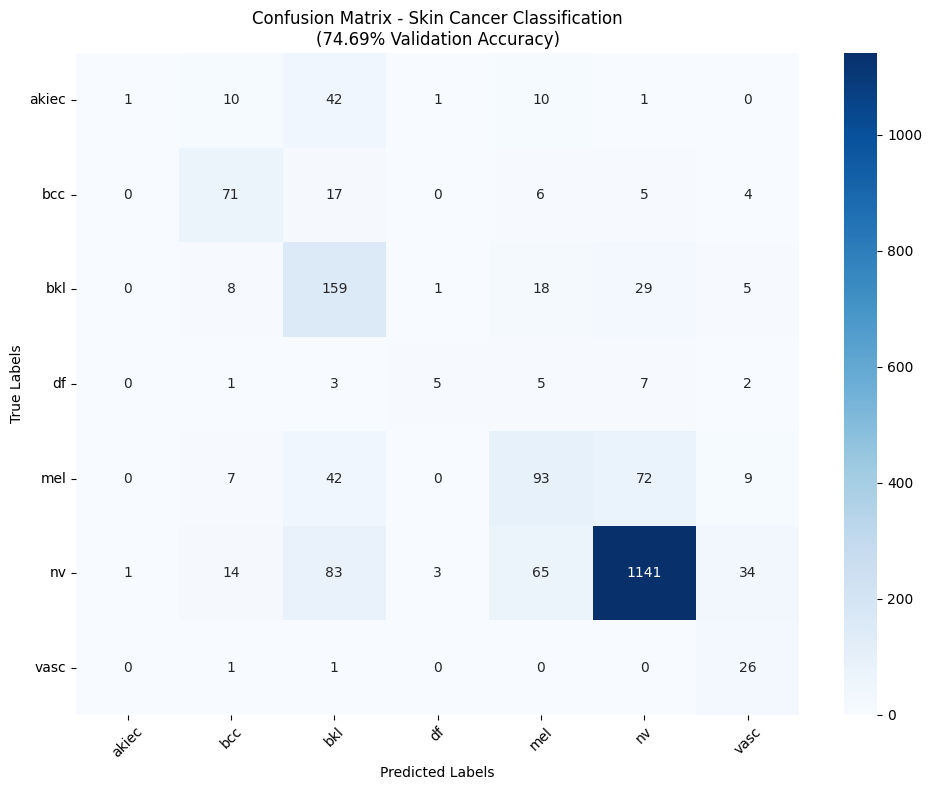


2. DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       akiec     0.5000    0.0154    0.0299        65
         bcc     0.6339    0.6893    0.6605       103
         bkl     0.4582    0.7227    0.5608       220
          df     0.5000    0.2174    0.3030        23
         mel     0.4721    0.4170    0.4429       223
          nv     0.9092    0.8509    0.8790      1341
        vasc     0.3250    0.9286    0.4815        28

    accuracy                         0.7469      2003
   macro avg     0.5426    0.5488    0.4797      2003
weighted avg     0.7707    0.7469    0.7446      2003


3. PERFORMANCE METRICS BY CLASS
   Class  Precision  Recall  F1-Score  Support
0  akiec     0.5000  0.0154    0.0299       65
1    bcc     0.6339  0.6893    0.6605      103
2    bkl     0.4582  0.7227    0.5608      220
3     df     0.5000  0.2174    0.3030       23
4    mel     0.4721  0.4170    0.4429      223
5     nv     0.9092  0.8509    0.8790     1341
6   va

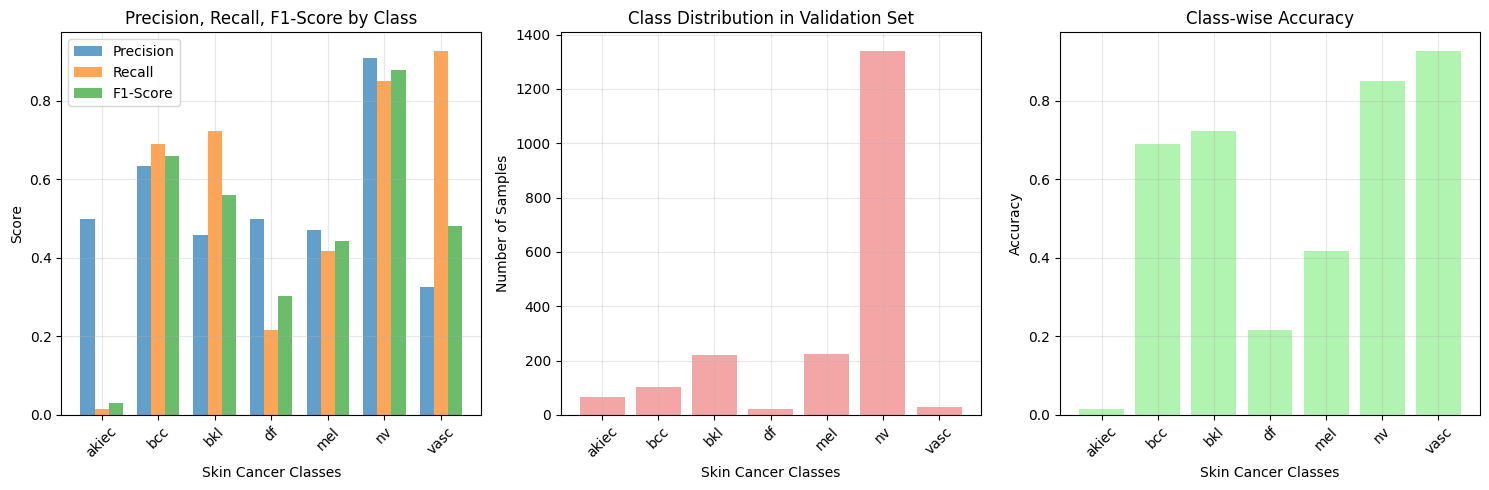


5. OVERALL PERFORMANCE SUMMARY
Overall Accuracy: 0.7469 (74.69%)
Weighted Precision: 0.7707
Weighted Recall: 0.7469
Weighted F1-Score: 0.7446

6. KEY INSIGHTS & RECOMMENDATIONS
🏆 Best performing class: vasc (92.86%)
🔧 Most challenging class: akiec (1.54%)
📈 Improvement over majority class baseline: 0.0774 (7.74%)
✅ Excellent! Model learned meaningful patterns beyond simple guessing


In [27]:
# Cell: COMPREHENSIVE MODEL EVALUATION
print("📊 COMPREHENSIVE MODEL EVALUATION - 74.69% ACCURACY")
print("=" * 50)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
from tensorflow.keras.models import load_model

# Load your best model
best_model = load_model('skin_cancer_final_model.h5')
print("✅ Loaded 74.69% accurate model")

# Get all predictions
print("\n🔍 GENERATING PREDICTIONS...")
val_generator.reset()
y_true = []
y_pred = []

# Collect all predictions from validation set
for i in range(len(val_generator)):
    batch_images, batch_labels = next(val_generator)
    batch_predictions = best_model.predict(batch_images, verbose=0)
    batch_pred_labels = np.argmax(batch_predictions, axis=1)

    y_true.extend(batch_labels)
    y_pred.extend(batch_pred_labels)

    if i >= len(val_generator) - 1:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert to class names for readability
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

print(f"✅ Predictions generated for {len(y_true)} validation samples")

# 1. CONFUSION MATRIX
print("\n1. CONFUSION MATRIX")
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Skin Cancer Classification\n(74.69% Validation Accuracy)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. CLASSIFICATION REPORT
print("\n2. DETAILED CLASSIFICATION REPORT")
print("=" * 40)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# 3. PRECISION, RECALL, F1-SCORE TABLE
print("\n3. PERFORMANCE METRICS BY CLASS")
print("=" * 50)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(metrics_df.round(4))

# 4. VISUALIZE METRICS
print("\n4. METRICS VISUALIZATION")
plt.figure(figsize=(15, 5))

# Precision, Recall, F1 by class
plt.subplot(1, 3, 1)
x_pos = np.arange(len(class_names))
width = 0.25

plt.bar(x_pos - width, precision, width, label='Precision', alpha=0.7)
plt.bar(x_pos, recall, width, label='Recall', alpha=0.7)
plt.bar(x_pos + width, f1, width, label='F1-Score', alpha=0.7)

plt.xlabel('Skin Cancer Classes')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-Score by Class')
plt.xticks(x_pos, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Support (number of samples)
plt.subplot(1, 3, 2)
plt.bar(class_names, support, color='lightcoral', alpha=0.7)
plt.xlabel('Skin Cancer Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Validation Set')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Accuracy by class (from confusion matrix)
plt.subplot(1, 3, 3)
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
plt.bar(class_names, class_accuracy, color='lightgreen', alpha=0.7)
plt.xlabel('Skin Cancer Classes')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. OVERALL PERFORMANCE SUMMARY
print("\n5. OVERALL PERFORMANCE SUMMARY")
print("=" * 40)
overall_accuracy = np.mean(y_true == y_pred)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted')

print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# 6. KEY INSIGHTS
print("\n6. KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 40)

# Find best and worst performing classes
best_class_idx = np.argmax(class_accuracy)
worst_class_idx = np.argmin(class_accuracy)

print(f"🏆 Best performing class: {class_names[best_class_idx]} ({class_accuracy[best_class_idx]:.2%})")
print(f"🔧 Most challenging class: {class_names[worst_class_idx]} ({class_accuracy[worst_class_idx]:.2%})")

# Check if model is better than random guessing
baseline_accuracy = np.max(np.bincount(y_true)) / len(y_true)
improvement = overall_accuracy - baseline_accuracy

print(f"📈 Improvement over majority class baseline: {improvement:.4f} ({improvement*100:.2f}%)")

if improvement > 0.05:
    print("✅ Excellent! Model learned meaningful patterns beyond simple guessing")
else:
    print("⚠️ Model performance close to baseline - may need improvement")